## GANITE(Tensorflow): Train and Evaluation

This notebook presents the solution for training and evaluating GANITE(Tensoflow version).

The implementation of GANITE is adapted in the local `ite` library.

First, make sure that all the depends are installed.
```
pip install -r requirements.txt
pip install .
```

### Setup

First, we import all the dependencies necessary for the task.

In [1]:
# Double check that we are using the correct interpreter.
import sys
print(sys.executable)

# Disable TF logging
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    
# 
import ite.algs.ganite.model as alg
import ite.datasets as ds
import ite.utils.tensorflow as utils

from matplotlib import pyplot as plt

import tensorflow.compat.v1 as tf

/home/bcebere/anaconda3/envs/cambridge/bin/python
Instructions for updating:
non-resource variables are not supported in the long term


### Load the Dataset



In [2]:
train_ratio = 0.8
 
[Train_X, Train_T, Train_Y, Opt_Train_Y, Test_X, Test_Y] = ds.load("twins", train_ratio)

### Load the model

In [3]:
dim = len(Train_X[0])
dim_hidden = 8
dim_outcome = Test_Y.shape[1]
 
model = alg.Ganite(
    dim, # number of features
    dim_hidden, # size of the hidden layers
    dim_outcome, # size of the output
    num_iterations=10000, # number of training iterations
    alpha=2, # alpha hyperparameter, used for the Generator block loss
    beta=2, # beta hyperparameter, used for the ITE block loss
    minibatch_size=128, # data batch size
    num_discr_iterations=10, # number of iterations executed by the discriminator.
)

assert model is not None

### Train

In [4]:
metrics = model.fit(Train_X, Train_T, Train_Y, Test_X, Test_Y)

  0%|          | 15/10000 [00:00<03:06, 53.46it/s]

Iter: 0
D_loss: 0.8794
G_loss: -1.614



  2%|▏         | 218/10000 [00:02<01:23, 117.06it/s]

Iter: 200
D_loss: 0.6588
G_loss: -1.143



  4%|▍         | 416/10000 [00:03<01:18, 122.01it/s]

Iter: 400
D_loss: 0.6315
G_loss: -1.146



  6%|▌         | 617/10000 [00:05<01:25, 110.36it/s]

Iter: 600
D_loss: 0.628
G_loss: -1.095



  8%|▊         | 822/10000 [00:07<01:24, 109.25it/s]

Iter: 800
D_loss: 0.6029
G_loss: -1.112



 10%|█         | 1017/10000 [00:09<01:09, 128.93it/s]

Iter: 1000
D_loss: 0.6103
G_loss: -1.156



 12%|█▏        | 1224/10000 [00:10<01:04, 136.21it/s]

Iter: 1200
D_loss: 0.5493
G_loss: -1.164



 14%|█▍        | 1422/10000 [00:12<01:09, 122.77it/s]

Iter: 1400
D_loss: 0.6935
G_loss: -1.232



 16%|█▌        | 1614/10000 [00:14<01:11, 117.92it/s]

Iter: 1600
D_loss: 0.654
G_loss: -1.274



 18%|█▊        | 1826/10000 [00:15<01:07, 121.87it/s]

Iter: 1800
D_loss: 0.6704
G_loss: -1.328



 20%|██        | 2014/10000 [00:17<01:08, 115.95it/s]

Iter: 2000
D_loss: 0.6912
G_loss: -1.358



 22%|██▏       | 2216/10000 [00:19<01:03, 123.09it/s]

Iter: 2200
D_loss: 0.6775
G_loss: -1.31



 24%|██▍       | 2416/10000 [00:20<01:01, 123.07it/s]

Iter: 2400
D_loss: 0.6821
G_loss: -1.34



 26%|██▌       | 2615/10000 [00:22<00:59, 124.61it/s]

Iter: 2600
D_loss: 0.6837
G_loss: -1.354



 28%|██▊       | 2821/10000 [00:24<01:01, 116.10it/s]

Iter: 2800
D_loss: 0.6831
G_loss: -1.399



 30%|███       | 3020/10000 [00:25<00:59, 117.76it/s]

Iter: 3000
D_loss: 0.6821
G_loss: -1.372



 32%|███▏      | 3224/10000 [00:27<00:57, 116.93it/s]

Iter: 3200
D_loss: 0.6935
G_loss: -1.376



 34%|███▍      | 3422/10000 [00:29<00:48, 134.48it/s]

Iter: 3400
D_loss: 0.6913
G_loss: -1.382



 36%|███▌      | 3622/10000 [00:30<00:46, 136.33it/s]

Iter: 3600
D_loss: 0.6765
G_loss: -1.36



 38%|███▊      | 3826/10000 [00:32<00:43, 141.35it/s]

Iter: 3800
D_loss: 0.6741
G_loss: -1.391



 40%|████      | 4015/10000 [00:33<00:45, 132.33it/s]

Iter: 4000
D_loss: 0.6896
G_loss: -1.403



 42%|████▏     | 4227/10000 [00:35<00:43, 131.72it/s]

Iter: 4200
D_loss: 0.6977
G_loss: -1.376



 44%|████▍     | 4424/10000 [00:36<00:43, 128.39it/s]

Iter: 4400
D_loss: 0.6814
G_loss: -1.407



 46%|████▌     | 4615/10000 [00:38<00:39, 135.17it/s]

Iter: 4600
D_loss: 0.6887
G_loss: -1.365



 48%|████▊     | 4816/10000 [00:39<00:38, 135.56it/s]

Iter: 4800
D_loss: 0.7077
G_loss: -1.376



 50%|█████     | 5018/10000 [00:41<00:35, 138.72it/s]

Iter: 5000
D_loss: 0.701
G_loss: -1.386



 52%|█████▏    | 5217/10000 [00:42<00:35, 135.24it/s]

Iter: 5200
D_loss: 0.6922
G_loss: -1.388



 54%|█████▍    | 5420/10000 [00:44<00:33, 138.66it/s]

Iter: 5400
D_loss: 0.6881
G_loss: -1.342



 56%|█████▌    | 5621/10000 [00:45<00:31, 138.45it/s]

Iter: 5600
D_loss: 0.6687
G_loss: -1.381



 58%|█████▊    | 5821/10000 [00:47<00:30, 136.89it/s]

Iter: 5800
D_loss: 0.6754
G_loss: -1.366



 60%|██████    | 6015/10000 [00:49<00:45, 87.33it/s] 

Iter: 6000
D_loss: 0.6991
G_loss: -1.342



 62%|██████▏   | 6220/10000 [00:50<00:32, 117.85it/s]

Iter: 6200
D_loss: 0.6878
G_loss: -1.385



 64%|██████▍   | 6412/10000 [00:52<00:37, 96.43it/s] 

Iter: 6400
D_loss: 0.6858
G_loss: -1.363



 66%|██████▌   | 6615/10000 [00:54<00:29, 113.16it/s]

Iter: 6600
D_loss: 0.682
G_loss: -1.387



 68%|██████▊   | 6828/10000 [00:56<00:23, 133.47it/s]

Iter: 6800
D_loss: 0.6712
G_loss: -1.37



 70%|███████   | 7023/10000 [00:58<00:22, 135.11it/s]

Iter: 7000
D_loss: 0.6864
G_loss: -1.351



 72%|███████▏  | 7221/10000 [00:59<00:20, 133.06it/s]

Iter: 7200
D_loss: 0.6864
G_loss: -1.383



 74%|███████▍  | 7408/10000 [01:00<00:19, 130.67it/s]

Iter: 7400
D_loss: 0.6801
G_loss: -1.369



 76%|███████▋  | 7626/10000 [01:02<00:17, 133.08it/s]

Iter: 7600
D_loss: 0.6832
G_loss: -1.382



 78%|███████▊  | 7826/10000 [01:04<00:16, 134.06it/s]

Iter: 7800
D_loss: 0.6931
G_loss: -1.363



 80%|████████  | 8028/10000 [01:05<00:14, 133.86it/s]

Iter: 8000
D_loss: 0.688
G_loss: -1.369



 82%|████████▏ | 8228/10000 [01:07<00:13, 135.36it/s]

Iter: 8200
D_loss: 0.6812
G_loss: -1.388



 84%|████████▍ | 8427/10000 [01:08<00:11, 136.03it/s]

Iter: 8400
D_loss: 0.6883
G_loss: -1.333



 86%|████████▌ | 8614/10000 [01:10<00:09, 140.38it/s]

Iter: 8600
D_loss: 0.6889
G_loss: -1.383



 88%|████████▊ | 8829/10000 [01:11<00:08, 138.28it/s]

Iter: 8800
D_loss: 0.69
G_loss: -1.373



 90%|█████████ | 9027/10000 [01:13<00:07, 132.13it/s]

Iter: 9000
D_loss: 0.6833
G_loss: -1.388



 92%|█████████▏| 9225/10000 [01:14<00:05, 137.58it/s]

Iter: 9200
D_loss: 0.6947
G_loss: -1.357



 94%|█████████▍| 9412/10000 [01:16<00:04, 136.83it/s]

Iter: 9400
D_loss: 0.6907
G_loss: -1.381



 96%|█████████▌| 9617/10000 [01:17<00:02, 134.15it/s]

Iter: 9600
D_loss: 0.6933
G_loss: -1.379



 98%|█████████▊| 9814/10000 [01:19<00:01, 137.59it/s]

Iter: 9800
D_loss: 0.6813
G_loss: -1.382



  2%|▏         | 151/10000 [00:00<00:14, 667.94it/s]

Iter: 0
I_loss: 1.28
Loss_sqrt_PEHE_Out: 0.9084
Loss_ATE_Out: 0.7849



  4%|▍         | 387/10000 [00:00<00:10, 914.95it/s]

Iter: 200
I_loss: 0.3618
Loss_sqrt_PEHE_Out: 0.3071
Loss_ATE_Out: 0.008872



  5%|▍         | 492/10000 [00:00<00:11, 797.24it/s]

Iter: 400
I_loss: 0.2767
Loss_sqrt_PEHE_Out: 0.3091
Loss_ATE_Out: 0.01343



  7%|▋         | 741/10000 [00:00<00:09, 946.77it/s]

Iter: 600
I_loss: 0.2899
Loss_sqrt_PEHE_Out: 0.3039
Loss_ATE_Out: 0.01013



 10%|▉         | 975/10000 [00:01<00:09, 962.50it/s]

Iter: 800
I_loss: 0.2405
Loss_sqrt_PEHE_Out: 0.3022
Loss_ATE_Out: 0.02074



 11%|█         | 1079/10000 [00:01<00:10, 852.87it/s]

Iter: 1000
I_loss: 0.2194
Loss_sqrt_PEHE_Out: 0.3023
Loss_ATE_Out: 0.02491



 13%|█▎        | 1343/10000 [00:01<00:09, 958.23it/s]

Iter: 1200
I_loss: 0.2175
Loss_sqrt_PEHE_Out: 0.3024
Loss_ATE_Out: 0.01636



 16%|█▌        | 1588/10000 [00:01<00:08, 957.17it/s]

Iter: 1400
I_loss: 0.2504
Loss_sqrt_PEHE_Out: 0.3029
Loss_ATE_Out: 0.0002764



 17%|█▋        | 1694/10000 [00:02<00:11, 695.59it/s]

Iter: 1600
I_loss: 0.2989
Loss_sqrt_PEHE_Out: 0.3022
Loss_ATE_Out: 0.0077



 19%|█▉        | 1892/10000 [00:02<00:11, 730.22it/s]

Iter: 1800
I_loss: 0.2161
Loss_sqrt_PEHE_Out: 0.302
Loss_ATE_Out: 0.006766



 21%|██▏       | 2129/10000 [00:02<00:09, 839.32it/s]

Iter: 2000
I_loss: 0.2885
Loss_sqrt_PEHE_Out: 0.3023
Loss_ATE_Out: 0.02342



 24%|██▎       | 2360/10000 [00:02<00:08, 908.17it/s]

Iter: 2200
I_loss: 0.2218
Loss_sqrt_PEHE_Out: 0.302
Loss_ATE_Out: 0.006277



 26%|██▌       | 2584/10000 [00:03<00:08, 914.24it/s]

Iter: 2400
I_loss: 0.2426
Loss_sqrt_PEHE_Out: 0.3016
Loss_ATE_Out: 0.005276



 27%|██▋       | 2684/10000 [00:03<00:09, 787.12it/s]

Iter: 2600
I_loss: 0.2455
Loss_sqrt_PEHE_Out: 0.3007
Loss_ATE_Out: 0.008677



 29%|██▉       | 2937/10000 [00:03<00:08, 868.36it/s]

Iter: 2800
I_loss: 0.1905
Loss_sqrt_PEHE_Out: 0.3017
Loss_ATE_Out: 0.006629



 32%|███▏      | 3178/10000 [00:03<00:07, 902.31it/s]

Iter: 3000
I_loss: 0.2514
Loss_sqrt_PEHE_Out: 0.3013
Loss_ATE_Out: 0.01561



 33%|███▎      | 3280/10000 [00:04<00:08, 795.65it/s]

Iter: 3200
I_loss: 0.203
Loss_sqrt_PEHE_Out: 0.3015
Loss_ATE_Out: 0.02281



 35%|███▌      | 3520/10000 [00:04<00:07, 848.60it/s]

Iter: 3400
I_loss: 0.2617
Loss_sqrt_PEHE_Out: 0.3013
Loss_ATE_Out: 0.001549



 37%|███▋      | 3742/10000 [00:04<00:07, 870.83it/s]

Iter: 3600
I_loss: 0.2455
Loss_sqrt_PEHE_Out: 0.301
Loss_ATE_Out: 0.006053



 39%|███▉      | 3922/10000 [00:04<00:08, 716.57it/s]

Iter: 3800
I_loss: 0.253
Loss_sqrt_PEHE_Out: 0.3012
Loss_ATE_Out: 0.01295



 41%|████▏     | 4134/10000 [00:05<00:07, 757.70it/s]

Iter: 4000
I_loss: 0.2633
Loss_sqrt_PEHE_Out: 0.301
Loss_ATE_Out: 0.01825



 44%|████▎     | 4355/10000 [00:05<00:06, 817.09it/s]

Iter: 4200
I_loss: 0.1601
Loss_sqrt_PEHE_Out: 0.3011
Loss_ATE_Out: 0.02378



 46%|████▌     | 4586/10000 [00:05<00:06, 849.00it/s]

Iter: 4400
I_loss: 0.232
Loss_sqrt_PEHE_Out: 0.3015
Loss_ATE_Out: 0.02783



 47%|████▋     | 4684/10000 [00:05<00:06, 761.73it/s]

Iter: 4600
I_loss: 0.239
Loss_sqrt_PEHE_Out: 0.3007
Loss_ATE_Out: 0.01255



 49%|████▉     | 4945/10000 [00:06<00:05, 888.14it/s]

Iter: 4800
I_loss: 0.2692
Loss_sqrt_PEHE_Out: 0.3011
Loss_ATE_Out: 0.01683



 52%|█████▏    | 5195/10000 [00:06<00:05, 937.50it/s]

Iter: 5000
I_loss: 0.2223
Loss_sqrt_PEHE_Out: 0.3011
Loss_ATE_Out: 0.001086



 53%|█████▎    | 5301/10000 [00:06<00:05, 801.49it/s]

Iter: 5200
I_loss: 0.1796
Loss_sqrt_PEHE_Out: 0.3006
Loss_ATE_Out: 0.01246



 55%|█████▌    | 5542/10000 [00:06<00:05, 874.91it/s]

Iter: 5400
I_loss: 0.257
Loss_sqrt_PEHE_Out: 0.3001
Loss_ATE_Out: 0.004337



 58%|█████▊    | 5792/10000 [00:07<00:04, 933.24it/s]

Iter: 5600
I_loss: 0.25
Loss_sqrt_PEHE_Out: 0.3002
Loss_ATE_Out: 0.003105



 59%|█████▉    | 5898/10000 [00:07<00:05, 810.68it/s]

Iter: 5800
I_loss: 0.1862
Loss_sqrt_PEHE_Out: 0.3001
Loss_ATE_Out: 0.008125



 61%|██████▏   | 6133/10000 [00:07<00:04, 849.14it/s]

Iter: 6000
I_loss: 0.2479
Loss_sqrt_PEHE_Out: 0.3006
Loss_ATE_Out: 0.01134



 64%|██████▍   | 6378/10000 [00:07<00:04, 898.26it/s]

Iter: 6200
I_loss: 0.2326
Loss_sqrt_PEHE_Out: 0.3013
Loss_ATE_Out: 0.02353



 65%|██████▍   | 6481/10000 [00:08<00:04, 759.59it/s]

Iter: 6400
I_loss: 0.2424
Loss_sqrt_PEHE_Out: 0.3006
Loss_ATE_Out: 0.01737



 67%|██████▋   | 6714/10000 [00:08<00:04, 795.00it/s]

Iter: 6600
I_loss: 0.2244
Loss_sqrt_PEHE_Out: 0.3008
Loss_ATE_Out: 0.005555



 69%|██████▉   | 6920/10000 [00:08<00:03, 784.05it/s]

Iter: 6800
I_loss: 0.2723
Loss_sqrt_PEHE_Out: 0.3
Loss_ATE_Out: 0.01476



 71%|███████▏  | 7144/10000 [00:09<00:03, 772.54it/s]

Iter: 7000
I_loss: 0.2669
Loss_sqrt_PEHE_Out: 0.3007
Loss_ATE_Out: 0.01814



 74%|███████▎  | 7366/10000 [00:09<00:03, 740.28it/s]

Iter: 7200
I_loss: 0.239
Loss_sqrt_PEHE_Out: 0.3005
Loss_ATE_Out: 0.01441



 76%|███████▌  | 7559/10000 [00:09<00:03, 721.90it/s]

Iter: 7400
I_loss: 0.2477
Loss_sqrt_PEHE_Out: 0.3006
Loss_ATE_Out: 0.01764



 78%|███████▊  | 7796/10000 [00:09<00:02, 815.58it/s]

Iter: 7600
I_loss: 0.2706
Loss_sqrt_PEHE_Out: 0.3004
Loss_ATE_Out: 0.01968



 79%|███████▉  | 7893/10000 [00:10<00:02, 709.52it/s]

Iter: 7800
I_loss: 0.2793
Loss_sqrt_PEHE_Out: 0.2997
Loss_ATE_Out: 0.01436



 81%|████████▏ | 8132/10000 [00:10<00:02, 778.00it/s]

Iter: 8000
I_loss: 0.2592
Loss_sqrt_PEHE_Out: 0.3009
Loss_ATE_Out: 0.02474



 84%|████████▎ | 8359/10000 [00:10<00:02, 802.07it/s]

Iter: 8200
I_loss: 0.2143
Loss_sqrt_PEHE_Out: 0.2997
Loss_ATE_Out: 0.0131



 85%|████████▌ | 8535/10000 [00:11<00:02, 694.83it/s]

Iter: 8400
I_loss: 0.28
Loss_sqrt_PEHE_Out: 0.2994
Loss_ATE_Out: 0.002312



 87%|████████▋ | 8727/10000 [00:11<00:01, 695.61it/s]

Iter: 8600
I_loss: 0.3327
Loss_sqrt_PEHE_Out: 0.2994
Loss_ATE_Out: 0.008219



 89%|████████▉ | 8938/10000 [00:11<00:01, 718.13it/s]

Iter: 8800
I_loss: 0.1885
Loss_sqrt_PEHE_Out: 0.2998
Loss_ATE_Out: 0.01561



 92%|█████████▏| 9166/10000 [00:12<00:01, 789.13it/s]

Iter: 9000
I_loss: 0.3628
Loss_sqrt_PEHE_Out: 0.2996
Loss_ATE_Out: 0.01326



 93%|█████████▎| 9260/10000 [00:12<00:01, 672.98it/s]

Iter: 9200
I_loss: 0.1993
Loss_sqrt_PEHE_Out: 0.2996
Loss_ATE_Out: 0.0159



 95%|█████████▌| 9524/10000 [00:12<00:00, 769.79it/s]

Iter: 9400
I_loss: 0.281
Loss_sqrt_PEHE_Out: 0.2999
Loss_ATE_Out: 0.01928



 97%|█████████▋| 9687/10000 [00:12<00:00, 607.58it/s]

Iter: 9600
I_loss: 0.2135
Loss_sqrt_PEHE_Out: 0.2996
Loss_ATE_Out: 0.01514



100%|██████████| 10000/10000 [00:13<00:00, 751.11it/s]

Iter: 9800
I_loss: 0.2408
Loss_sqrt_PEHE_Out: 0.2994
Loss_ATE_Out: 0.009885



### Plot train metrics on the test set

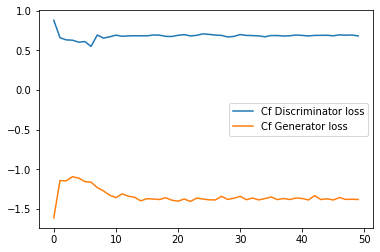

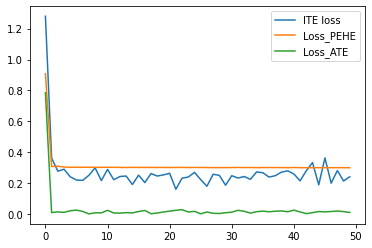

In [5]:
plt.plot(metrics["gen_block"]["D_loss"], label="Cf Discriminator loss")
plt.plot(metrics["gen_block"]["G_loss"], label="Cf Generator loss")
plt.legend()
plt.show()

plt.plot(metrics["ite_block"]["I_loss"], label="ITE loss")
plt.plot(metrics["ite_block"]["Loss_sqrt_PEHE"], label="Loss_PEHE")
plt.plot(metrics["ite_block"]["Loss_ATE"], label="Loss_ATE")
plt.legend()
plt.show()

### Predict

You can use run inferences on the model and evaluate the output.

In [6]:
sess = tf.InteractiveSession()

hat_y = model.predict(Test_X)

utils.sqrt_PEHE(hat_y, Test_Y).eval()

0.2999897052842235

### Test
Will can run inferences and get metrics directly

In [7]:
test_metrics = model.test(Test_X, Test_Y)

test_metrics["sqrt_PEHE"]

0.29998970388656554